In [1]:
"""
Author: Peizhi Yan
Date Updated: Sep.-21-2021
"""

'\nWe use CelebA dataset as training data in this experiment\n--------------------------------------------------------\nMethod Brief Description:\nTraining STEPS:\n\n\n\n--------------------------------------------------------\nAuthor: Peizhi Yan\nDate Updated: Sep.-21-2021\n'

In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    
    

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


In [2]:
shape_path = '..dDatasets/FFHQ/raw_bfm_shape/{}.npy'


img_indices = []
for fname in os.listdir('../datasets/FFHQ/raw_bfm_shape/'):
    if fname.endswith('.npy'):
         img_indices.append(fname[:-4])

print(len(img_indices))


68422


In [3]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    #'S_rest':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


In [4]:

def o3d_render(V, T, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    if T is not None:
        o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
    o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    vis.add_geometry(o3d_mesh)
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image


In [5]:
#np.save('ffhq_meanshape.npy', ffhq_meanshape) # [1, V, 3]
ffhq_meanshape = np.load('ffhq_meanshape.npy')

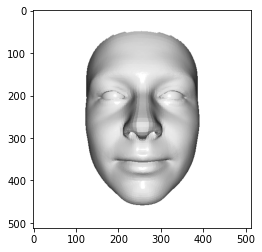

In [6]:
mesh, img = o3d_render(ffhq_meanshape[0], None, Faces)
plt.imshow(img)
o3d.visualization.draw_geometries([mesh])

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, n_vert):
        super(Encoder, self).__init__()
        self.n_vert = n_vert
        self.fc1 = nn.Linear(3*self.n_vert, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3_mu = nn.Linear(128, latent_dim)
        self.fc3_std = nn.Linear(128, latent_dim)
        
    def forward(self, x):
        #h = x
        h = torch.flatten(x, start_dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        mu = self.fc3_mu(h)
        sigma = torch.exp(self.fc3_std(h))
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, n_vert):
        super(Decoder, self).__init__()
        self.n_vert = n_vert
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 3*self.n_vert)
        
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_ = self.fc3(h)
        return torch.reshape(x_, [-1, self.n_vert, 3])
    
    
class VAE(nn.Module):
    def __init__(self, latent_dim, n_vert):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, n_vert)
        self.decoder = Decoder(latent_dim, n_vert)
        
        self.normal = torch.distributions.Normal(0, 1) # a normal distribution with mean = 0, std = 1
        if device.type == 'cuda':
            self.normal.loc = self.normal.loc.cuda() # use CUDA GPU for sampling
            self.normal.scale = self.normal.scale.cuda()
        self.kl_loss = 0 # KL divergence loss
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = mu + sigma * self.normal.sample(mu.size())
        self.kl_loss = torch.mean(torch.sum(-0.5 * (1 + sigma - mu**2 - torch.exp(sigma)), dim=1))
        x_ = self.decoder(z)
        return x_

    
vae = VAE(latent_dim=30, n_vert=len(part_vertices)).to(device)
print('VAE model on CUDA: ', next(vae.parameters()).is_cuda) # True

part_vaes = {}
for key in part_vertices:
    if key == 'S_overall':
        latent_dim = 30
    else:
        latent_dim = 10
    vae = VAE(latent_dim=latent_dim, n_vert=len(part_vertices[key])).to(device)
    vae.load_state_dict(torch.load('../saved_models/part_vaes/{}'.format(key)))
    part_vaes[key] = vae
    print('{} VAE model on CUDA: '.format(key), next(vae.parameters()).is_cuda) # True
    


VAE model on CUDA:  True
S_overall VAE model on CUDA:  True
S_eyebrows VAE model on CUDA:  True
S_eyes VAE model on CUDA:  True
S_llip VAE model on CUDA:  True
S_nose VAE model on CUDA:  True
S_ulip VAE model on CUDA:  True


Text(0.5, 1.0, 'reconstructed mean mesh')

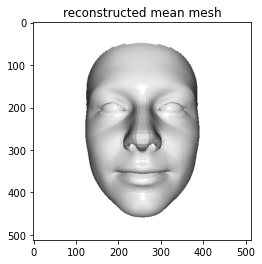

In [8]:
reconstructed = part_vaes['S_overall'](torch.from_numpy(ffhq_meanshape).to(device))

mesh, img = o3d_render(reconstructed[0].detach().cpu().numpy(), None, Faces)
plt.imshow(img)
plt.title('reconstructed mean mesh')

In [9]:
def standardize_part_shape(part_shapes):
    # part_shapes: [n, n_vert, 3]  n -- batch size
    y_max, _ = torch.max(part_shapes[...,1], dim=1) # [n, 1]
    y_min, _ = torch.min(part_shapes[...,1], dim=1) # [n, 1]
    y_center = (y_max + y_min) / 2 # [n, 1]
    z_max, _ = torch.max(part_shapes[...,2], dim=1) # [n, 1]
    z_min, _ = torch.min(part_shapes[...,2], dim=1) # [n, 1]
    z_center = (z_max + z_min) / 2 # [n, 1]
    batch_size = part_shapes.shape[0]
    for i in range(batch_size):
        part_shapes[i, :, 1] -= y_center[i]
        part_shapes[i, :, 2] -= z_center[i]
    return part_shapes


In [10]:
"""process and save all ffhq shape latent vectors"""

part_latents = {}

file_indices = np.zeros([len(img_indices)], dtype=int)

for key in part_vertices:
    if key == 'S_overall':
        part_latents[key] = np.zeros([len(img_indices), 30], dtype=np.float32)
    else:
        part_latents[key] = np.zeros([len(img_indices), 10], dtype=np.float32)
        
counter = 0
for idx in tqdm(img_indices):
    shape = np.load(shape_path.format(idx))
    file_indices[counter] = int(idx)
    for key in part_vertices:
        part_shape = torch.from_numpy(shape[:,part_vertices[key],:]).to(device)
        if key != 'S_overall':
            part_shape = standardize_part_shape(part_shape)
        mu, sigma = part_vaes[key].encoder(part_shape)
        part_latents[key][counter, :] = mu.detach().cpu().numpy()
    counter += 1
                
for key in part_vertices:
    np.save('./cache/shape_latents/{}.npy'.format(key), part_latents[key])

np.save('./cache/shape_latents/file_indices.npy', file_indices)
    

100%|████████████████████████████████████████████████████████████████████████████| 68422/68422 [17:21<00:00, 65.67it/s]
